In [7]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [8]:
tickers = 'GC=F'
period = '6mo'
interval = '1m'

In [9]:
data = yf.download('TSLA', start='2012-01-01', end='2022-07-24',interval='1d', auto_adjust= True, prepost = True)

[*********************100%***********************]  1 of 1 completed


In [10]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,5.788000,5.900000,5.530000,5.616000,4640500
2012-01-04,5.642000,5.734000,5.500000,5.542000,3150500
2012-01-05,5.552000,5.586000,5.370000,5.424000,5027500
2012-01-06,5.440000,5.558000,5.282000,5.382000,4931500
2012-01-09,5.400000,5.498000,5.224000,5.450000,4485000
...,...,...,...,...,...
2022-07-18,734.809998,751.549988,718.809998,721.640015,27512500
2022-07-19,735.000000,741.419983,710.929993,736.590027,26963400
2022-07-20,740.349976,751.989990,730.450012,742.500000,29621400


<AxesSubplot:xlabel='Date'>

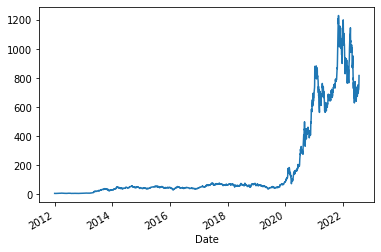

In [11]:
data.Close.plot()

In [12]:
data.shape

(2656, 5)

In [13]:
def ts_data(data, x_steps, y_steps):
    #Split train and test data by date
    train_data = data[:'2021'].Close.values.reshape(-1,1)
    test_data = data['2022':].Close.values.reshape(-1,1)
    #Normolize train data
    sc = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = sc.fit_transform(train_data)
    
    x_train = []
    y_train = []
    
    for i in range(x_steps, len(train_data_scaled) - 1):
        x_train.append(train_data_scaled[i-x_steps:i, 0])
        y_train.append(train_data_scaled[i:i+y_steps, 0])
        
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

    #assemble test data
    x = data.Close.values
    x = x[len(x) - len(test_data) - x_steps:] 
    x = x.reshape(-1,1)
    x = sc.transform(x)
    
    x_test = []
    y_test = []
    
    for i in range(x_steps, len(test_data) + x_steps - y_steps):
        x_test.append(x[i-x_steps:i,0])
        y_test.append(x[i:i+y_steps,0])
        
    x_test = np.array(x_test)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    y_test = np.array(y_test)
    
    return x_train, y_train, x_test, y_test, sc

In [14]:
x_train, y_train, x_test, y_test, sc = ts_data(data,6,2)

### SimpleRNN-Model

In [15]:
simple_rnn_model = Sequential([
                                SimpleRNN(50, return_sequences=True),
                                SimpleRNN(50),
                                Dense(2)
                                ])

In [16]:
simple_rnn_model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
simple_rnn_model.fit(x_train, y_train, epochs=100, validation_split=0.1)

Epoch 1/100
71/71 [==============================] - 1s 4ms/step - loss: 8.1851e-04 - val_loss: 0.0072
Epoch 2/100
71/71 [==============================] - 0s 2ms/step - loss: 1.0287e-04 - val_loss: 0.0064
Epoch 3/100
71/71 [==============================] - 0s 1ms/step - loss: 1.0490e-04 - val_loss: 0.0063
Epoch 4/100
71/71 [==============================] - 0s 1ms/step - loss: 1.0726e-04 - val_loss: 0.0023
Epoch 5/100
71/71 [==============================] - 0s 1ms/step - loss: 7.7060e-05 - val_loss: 0.0026
Epoch 6/100
71/71 [==============================] - 0s 1ms/step - loss: 5.6243e-05 - val_loss: 0.0023
Epoch 7/100
71/71 [==============================] - 0s 2ms/step - loss: 7.2626e-05 - val_loss: 0.0015
Epoch 8/100
71/71 [==============================] - 0s 1ms/step - loss: 6.6225e-05 - val_loss: 0.0023
Epoch 9/100
71/71 [==============================] - 0s 2ms/step - loss: 6.3001e-05 - val_loss: 0.0013
Epoch 10/100
71/71 [==============================] - 0s 1ms/step - loss:

In [18]:
simple_rnn_pred = simple_rnn_model.predict(x_test)
simple_rnn_pred.shape

5/5 [==============================] - 0s 0s/step


(137, 2)

In [19]:
from cProfile import label


def prediction_plot(prediction):
    fig, ax = plt.subplots()
    ax.plot(data['2022':].index[:len(y_test)], sc.inverse_transform(y_test[:, 0].reshape(-1,1)), label='Real')
    ax.plot(data['2022':].index[:len(y_test)], sc.inverse_transform(prediction[:, 0].reshape(-1,1)), label='Prediction')

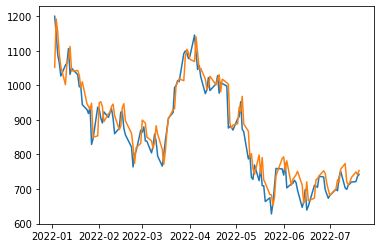

In [20]:
prediction_plot(simple_rnn_pred)